In [28]:
import numpy as np
import pandas as pd
import json
import csv
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import PIL.Image as Image  
import cv2
import imageio
import re
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
from textblob import TextBlob

In [9]:
df = pd.read_excel('US.xlsx')
df.head()

,video_id,trending_date,title,channel_title,category_id,category,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,People & Blogs,2017-11-13,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Entertainment,2017-11-13,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Comedy,2017-11-12,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Entertainment,2017-11-13,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,Entertainment,2017-11-12,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,I know it's been a while since we did this sho...


In [14]:
df.shape

(39065, 15)

In [90]:
title = df['title']
tags = df['tags']
views = df['views']
likes = df['likes']
comment_count = df['comment_count']
dislikes = df['dislikes']
description = df['description']

In [64]:
sentiment = []
for i in range(39065):
    string = df.loc[i, 'description']
    string = re.sub(r'\\n','\n',string)
    string = re.sub(r'-','\n',string)
    results = re.compile(r'[http|https]*://[a-zA-Z0-9.?/&=:]*', re.S)
    string = re.sub(results,'',string)
    string.rstrip() 
    blob = TextBlob(string)
    sentiment.append(blob.sentiment)
print(sentiment[0:5])
type(sentiment)

[Sentiment(polarity=0.07291666666666669, subjectivity=0.3885416666666667), Sentiment(polarity=0.07916666666666666, subjectivity=0.3458333333333334), Sentiment(polarity=0.027083333333333348, subjectivity=0.4666666666666667), Sentiment(polarity=0.062373737373737366, subjectivity=0.44217171717171716), Sentiment(polarity=0.514090909090909, subjectivity=0.390909090909091)]


list

In [91]:
sent = re.findall(r'\d{0,1}\.\d+',str(sentiment))

In [92]:
polarity = []
subjectivity = []
for i in range(0,78130,2):
    polarity.append(float(sent[i]))
#print(polarity)
for i in range(1,78130,2):
    subjectivity.append(float(sent[i]))
#print(subjectivity)

In [106]:
pola = pd.DataFrame(polarity, columns = ['polarity'])
subjectivity = pd.DataFrame(polarity, columns = ['subjectivity'])
result1 = pd.concat([pola,views], axis=1,join='inner')
result2 = pd.concat([result1,subjectivity], axis=1,join='inner')
#result2['propo'] = result2['comment_count']/result2['views']
result2['views_log'] = pd.DataFrame(np.log(result2['views']))
result2 = result2.drop(['views'], axis=1,inplace=False)
result2 = result2.drop(result2[result2['polarity']>1].index)
result2.head()

,polarity,subjectivity,views_log
0,0.072917,0.072917,13.525658
1,0.079167,0.079167,14.698775
2,0.027083,0.027083,14.975981
3,0.062374,0.062374,12.745975
4,0.514091,0.514091,14.555413


In [107]:
result2_ar = np.array(result2)
result2_ar

array([[ 0.07291667,  0.07291667, 13.52565813],
       [ 0.07916667,  0.07916667, 14.69877508],
       [ 0.02708333,  0.02708333, 14.9759809 ],
       ...,
       [ 0.14320501,  0.14320501, 13.87984687],
       [ 0.02478355,  0.02478355, 15.54907808],
       [ 0.16458333,  0.16458333, 16.14824835]])

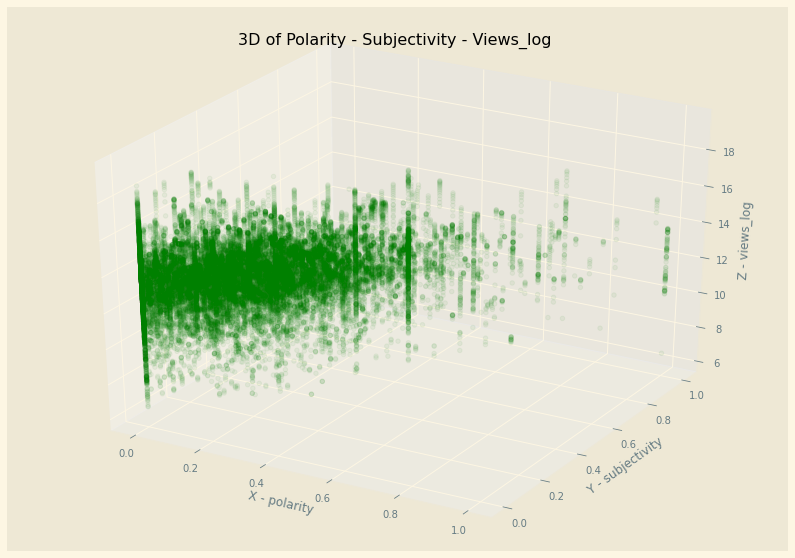

In [119]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d  
figure = plt.figure(figsize=(14,10))
axes = Axes3D(figure)

x = [x[0] for x in result2_ar]
y = [x[1] for x in result2_ar]
z = [x[2] for x in result2_ar]
 
ax = plt.subplot(projection = '3d')  
ax.set_title('3D of Polarity - Subjectivity - Views_log ')  
ax.scatter(x, y, z, c = 'g', alpha = 0.05)   
 
ax.set_xlabel('X - polarity')  
ax.set_ylabel('Y - subjectivity') 
ax.set_zlabel('Z - views_log')  
 
plt.show()

#### 数据处理

In [38]:
pola = pd.DataFrame(polarity, columns = ['polarity'])
result1 = pd.concat([pola,views], axis=1,join='inner')
result2 = pd.concat([result1,comment_count], axis=1,join='inner')
result2['propo'] = result2['comment_count']/result2['views']
result2.head()

,polarity,views,comment_count,propo
0,0.072917,748374,15954,0.021318
1,0.079167,2418783,12703,0.005252
2,0.027083,3191434,8181,0.002563
3,0.062374,343168,2146,0.006253
4,0.514091,2095731,17518,0.008359


In [42]:
result2 = result2.drop(result2[result2['polarity']>1].index)
result2.head()

,polarity,views,comment_count,propo
0,0.072917,748374,15954,0.021318
1,0.079167,2418783,12703,0.005252
2,0.027083,3191434,8181,0.002563
3,0.062374,343168,2146,0.006253
4,0.514091,2095731,17518,0.008359


In [51]:
polarity = result2['polarity']
propo = result2['propo']
# mean = np.mean(propo)
# mean
result2['propo_cl'] = result2['propo'].map(lambda s :1  if s >= result2['propo'].mean() else 0)
result2.head()

,polarity,views,comment_count,propo,propo_cl
0,0.072917,748374,15954,0.021318,1
1,0.079167,2418783,12703,0.005252,1
2,0.027083,3191434,8181,0.002563,0
3,0.062374,343168,2146,0.006253,1
4,0.514091,2095731,17518,0.008359,1


#### 逻辑回归

In [54]:
result2_data = np.array(result2)

In [55]:
X = result2_data[:,0]  
y = result2_data[:,-1]
y = y.astype('int') #转化为整数
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [56]:
print(X_train.shape)
print(X_test.shape)

(29293,)
(9765,)


In [59]:
model1 = linear_model.LogisticRegression()
Xlr_train = X_train.reshape(-1, 1)
Xlr_test = X_test.reshape(-1, 1)

model1.fit(Xlr_train,y_train.astype('int'))
print('Coefficient: ', model1.coef_)
print('Intercept: ', model1.intercept_)

ylr_pred = model1.predict(Xlr_test)
ylr_pred_prob =  model1.predict_proba(Xlr_test)

Coefficient:  [[0.09556833]]
Intercept:  [-0.79070732]


In [60]:
from sklearn.metrics import confusion_matrix

CM_lr = confusion_matrix(y_test, ylr_pred)
print(CM_lr)

[[6672    0]
 [3093    0]]


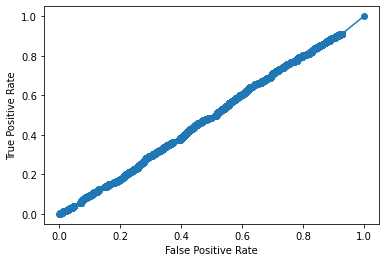

0.493905239532913

In [61]:
#Calculate out-of-sample AUC
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(y_test.astype('int'), ylr_pred_prob[:,1])
#Draw the ROC curve
plt.plot(fpr,tpr,marker = 'o')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
auc(fpr, tpr)